In [1]:
import pandas as pd

# Load the dataset
df = pd.read_csv('[RAW] Mid-TermProject_16-09-27_Data_5percent.csv')
print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 258000 entries, 0 to 257999
Columns: 137 entries, DeviceName to udp.time_relative
dtypes: bool(6), float64(64), int64(5), object(62)
memory usage: 259.3+ MB
None


In [2]:
df.head()

,DeviceName,Frame_length,Frame_protocols_in,arp.dst_hw_mac,arp.dst_proto_ipv4,arp.hw_size,arp.hw_type,arp.opcode,arp.proto_size,arp.proto_type,...,udp.checksum,udp.checksum_status,udp.dstport,udp.length,udp.port,udp.srcport,udp.stream,udp.stream_pnum,udp.time_delta,udp.time_relative
0,Dropcam,156,eth:ethertype:ip:tcp:tls,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,TPLink Router Bridge LAN (Gateway),66,eth:ethertype:ip:tcp,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,Dropcam,284,eth:ethertype:ip:tcp:tls,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,Dropcam,156,eth:ethertype:ip:tcp:tls,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,TPLink Router Bridge LAN (Gateway),90,eth:ethertype:ip:udp:ntp,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0xb440,2.0,4967.0,56.0,123.0,123.0,0.0,1.0,0.0,0.0


In [3]:
print("Original shape:", df.shape)
df = df.drop(['eth.addr', 'eth.addr_oui', 'eth.addr_oui_resolved', 'eth.addr_resolved',
              'eth.dst', 'eth.dst_oui_resolved', 'eth.dst_resolved', 'eth.src', 'eth.src_ig',
              'eth.src_lg', 'eth.src_oui', 'eth.src_oui_resolved', 'eth.src_resolved', 'ip.addr',
              'ip.dst', 'ip.dst_host', 'ip.host', 'ip.src', 'ip.src_host', 'arp.dst_hw_mac',
              'arp.dst_proto_ipv4', 'arp.src_hw_mac', 'arp.src_proto_ipv4'], axis=1)
print("Shape after removing unreliable data:", df.shape)

Original shape: (258000, 137)
Shape after removing unreliable data: (258000, 114)


In [4]:
# Drop duplicate rows
df = df.drop_duplicates(keep="first")
print("Shape after removing duplicate rows:", df.shape)

Shape after removing duplicate rows: (217509, 114)


In [5]:
print("Empty values in the dataset:")
print(df.isna().sum().sort_values())
print("\nTotal:", df.isna().sum().sum())

Empty values in the dataset:
DeviceName             0
eth.stream             0
eth.ig                 0
eth.dst_oui            0
eth.dst_lg             0
                   ...  
arp.hw_size       217442
arp.opcode        217442
arp.proto_size    217442
arp.hw_type       217442
arp.proto_type    217442
Length: 114, dtype: int64

Total: 9696721


In [6]:
# Impute missing values
from sklearn.impute import SimpleImputer

# For numerical columns with only 1 type of value (and N/A), replace N/A with zeroes
numerical_cols = df.select_dtypes(include=['float64', 'int64']).columns
for i in df[numerical_cols]:
    if (len(df[i].unique()) < 2):
        df[numerical_cols] = df[numerical_cols].fillna(0)

# For other numerical columns, simply replace empty values with the mean
num_imputer = SimpleImputer(strategy='mean')
df[numerical_cols] = num_imputer.fit_transform(df[numerical_cols])

# For string columns with only 1 type of value (and N/A), replace N/A with the string "N/A"
object_cols = df.select_dtypes(include=['object']).columns
for a in df[object_cols]:
    if (len(df[a].unique()) < 2):
        df[a] = df[a].fillna("N/A")
# For boolean columns with only 1 type of value (and N/A), replace N/A with the inverse of that boolean
bool_cols = df.select_dtypes(include=['bool']).columns
for b in df[bool_cols]:
    if (len(df[b].unique()) < 2):
        df[b] = df[b].fillna(not bool(df[b].mode()[0]))
categorical_cols = df.select_dtypes(include=['object', 'bool']).columns

# For other categorical columns, simply replace empty values with the mode
cat_imputer = SimpleImputer(strategy="most_frequent")
df[categorical_cols] = cat_imputer.fit_transform(df[categorical_cols])

print("Empty values after imputing:")
print(df.isna().sum())
print("\nTotal:", df.isna().sum().sum())

Empty values after imputing:
DeviceName            0
Frame_length          0
Frame_protocols_in    0
arp.hw_size           0
arp.hw_type           0
                     ..
udp.srcport           0
udp.stream            0
udp.stream_pnum       0
udp.time_delta        0
udp.time_relative     0
Length: 114, dtype: int64

Total: 0


In [7]:
# Feature encoding for categorical columns
from sklearn.preprocessing import OneHotEncoder

categorical_features = categorical_cols.drop(['DeviceName'])

print("Dropping categorical features with too many different values:")
for i in df[categorical_features]:
    if (len(df[i].unique()) > 50):
        print("\t", i, ": " , len(df[i].unique()), sep="")
        categorical_features = categorical_features.drop([str(i)])
df[categorical_features].head()

Dropping categorical features with too many different values:
	Frame_protocols_in: 64
	icmp.checksum: 9384
	ip.checksum: 63301
	ip.id: 62293
	tcp._ws_expert: 144
	tcp._ws_expert_message: 144
	tcp.checksum: 60297
	tcp.options: 141096
	tcp.options_timestamp: 141018
	udp.checksum: 5645


,arp.proto_type,eth.dst_ig,eth.dst_lg,eth.ig,eth.lg,eth.type,icmp.data,ip.dsfield,ip.flags,ip.flags_df,...,tcp.flags_fin,tcp.flags_push,tcp.flags_res,tcp.flags_reset,tcp.flags_str,tcp.flags_syn,tcp.flags_urg,tls.record,tls.record_version,udp.
0,0x0800,False,False,False,False,0x0800,08090a0b0c0d0e0f101112131415161718191a1b1c1d1e...,0x00,0x02,True,...,False,True,False,False,·······AP···,False,False,TLSv1 Record Layer: Application Data Protocol:...,0x0301,Timestamps
1,0x0800,False,False,False,False,0x0800,08090a0b0c0d0e0f101112131415161718191a1b1c1d1e...,0x00,0x02,True,...,False,False,False,False,·······A····,False,False,TLSv1 Record Layer: Application Data Protocol:...,0x0301,Timestamps
2,0x0800,False,False,False,False,0x0800,08090a0b0c0d0e0f101112131415161718191a1b1c1d1e...,0x00,0x02,True,...,False,True,False,False,·······AP···,False,False,TLSv1 Record Layer: Application Data Protocol:...,0x0301,Timestamps
3,0x0800,False,False,False,False,0x0800,08090a0b0c0d0e0f101112131415161718191a1b1c1d1e...,0x00,0x02,True,...,False,True,False,False,·······AP···,False,False,TLSv1 Record Layer: Application Data Protocol:...,0x0301,Timestamps
4,0x0800,False,False,False,False,0x0800,08090a0b0c0d0e0f101112131415161718191a1b1c1d1e...,0x18,0x02,True,...,False,False,False,False,·······A····,False,False,TLSv1 Record Layer: Application Data Protocol:...,0x0301,Timestamps


In [8]:
print("Initializing OneHotEncoder...")
encoder = OneHotEncoder(sparse_output=False)
# Fit and transform the categorical features
print("Fitting data...")
encoder.fit(df[categorical_features])
print("Transforming data...")
encoded = encoder.transform(df[categorical_features])
print("Converting into DataFrame...")
df_encoded = pd.DataFrame(encoded, columns=encoder.get_feature_names_out(categorical_features))

df_encoded.head()

Initializing OneHotEncoder...
Fitting data...
Transforming data...
Converting into DataFrame...


,arp.proto_type_0x0800,eth.dst_ig_False,eth.dst_ig_True,eth.dst_lg_False,eth.dst_lg_True,eth.ig_False,eth.ig_True,eth.lg_False,eth.lg_True,eth.type_0x0800,...,tls.record_TLSv1.2 Record Layer: Handshake Protocol: Client Key Exchange,tls.record_TLSv1.2 Record Layer: Handshake Protocol: Encrypted Handshake Message,tls.record_TLSv1.2 Record Layer: Handshake Protocol: Multiple Handshake Messages,tls.record_TLSv1.2 Record Layer: Handshake Protocol: New Session Ticket,tls.record_TLSv1.2 Record Layer: Handshake Protocol: Server Hello,tls.record_TLSv1.2 Record Layer: Handshake Protocol: Server Hello Done,tls.record_TLSv1.2 Record Layer: Handshake Protocol: Server Key Exchange,tls.record_version_0x0301,tls.record_version_0x0303,udp._Timestamps
0,1.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0
1,1.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0
2,1.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0
3,1.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0
4,1.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0


In [9]:
df = df.reset_index(drop=True)
df_encoded = df_encoded.reset_index(drop=True)

print("Concatenating encoded columns with numerical...")
X = pd.concat([df.drop(columns=categorical_cols), df_encoded], axis=1)
print("Features (x):")
X.head()

Concatenating encoded columns with numerical...
Features (x):


,Frame_length,arp.hw_size,arp.hw_type,arp.opcode,arp.proto_size,eth.dst_oui,eth.stream,icmp.checksum_status,icmp.code,icmp.data_len,...,tls.record_TLSv1.2 Record Layer: Handshake Protocol: Client Key Exchange,tls.record_TLSv1.2 Record Layer: Handshake Protocol: Encrypted Handshake Message,tls.record_TLSv1.2 Record Layer: Handshake Protocol: Multiple Handshake Messages,tls.record_TLSv1.2 Record Layer: Handshake Protocol: New Session Ticket,tls.record_TLSv1.2 Record Layer: Handshake Protocol: Server Hello,tls.record_TLSv1.2 Record Layer: Handshake Protocol: Server Hello Done,tls.record_TLSv1.2 Record Layer: Handshake Protocol: Server Key Exchange,tls.record_version_0x0301,tls.record_version_0x0303,udp._Timestamps
0,156.0,6.0,1.0,1.462687,4.0,1362976.0,0.0,1.0,0.040768,58.721158,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0
1,66.0,6.0,1.0,1.462687,4.0,3181819.0,0.0,1.0,0.040768,58.721158,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0
2,284.0,6.0,1.0,1.462687,4.0,1362976.0,0.0,1.0,0.040768,58.721158,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0
3,156.0,6.0,1.0,1.462687,4.0,1362976.0,0.0,1.0,0.040768,58.721158,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0
4,90.0,6.0,1.0,1.462687,4.0,13652648.0,1.0,1.0,0.040768,58.721158,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0


In [10]:
y = df['DeviceName']
print('Label (y):', y.name)
print(f"Classes ({len(y.unique())}):\n", y.unique())

Label (y): DeviceName
Classes (18):
 ['Dropcam' 'TPLink Router Bridge LAN (Gateway)' 'Netatmo Welcome '
 'Amazon Echo' 'Smart Things' 'Withings Smart Baby Monitor '
 'Samsung SmartCam ' 'TP-Link Day Night Cloud camera '
 'Belkin Wemo switch ' 'Triby Speaker' 'HP Printer'
 'Belkin wemo motion sensor ' 'PIX-STAR Photo-frame '
 'TP-Link Smart plug ' 'Netatmo weather station ' 'Samsung Galaxy Tab'
 'NEST Protect smoke alarm ' 'Withings Smart scale ']


In [11]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from matplotlib import pyplot as plt
import numpy as np


print("Train/test split...", end=" ")
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)
print("Done")

Train/test split... Done


Preparing plot...
Iteration 1/9...
Iteration 2/9...
Iteration 3/9...
Iteration 4/9...
Iteration 5/9...
Iteration 6/9...
Iteration 7/9...
Iteration 8/9...
Iteration 9/9...
Plotting...


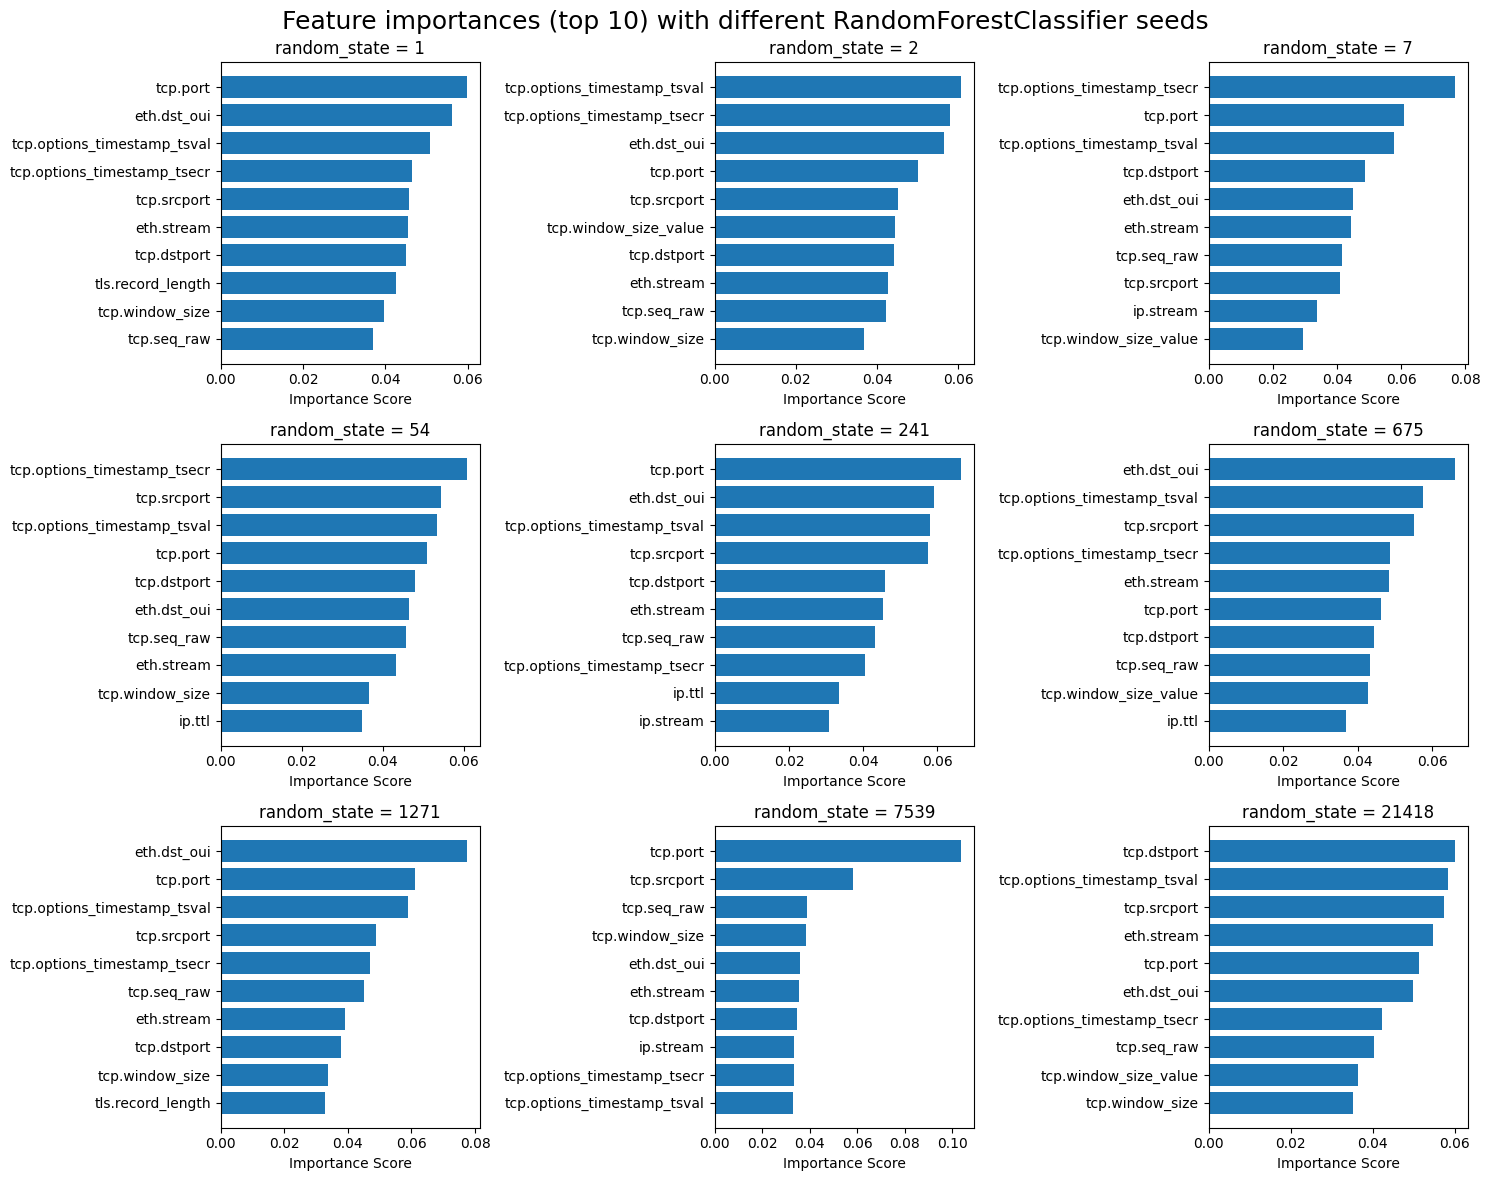

In [12]:
seeds = [1, 2, 7, 54, 241, 675, 1271, 7539, 21418] # Seeds for reproducibility
top_n = 10 # Use 10 most important features
all_importances = np.zeros((len(seeds), len(X_train.columns))) # Store importances with every seed to compute mean later

print("Preparing plot...")

# Create a 3x3 grid of subplots
fig, axes = plt.subplots(3, 3, figsize=(15, 12))
fig.suptitle('Feature importances (top 10) with different RandomForestClassifier seeds', fontsize=18)

for i, seed in enumerate(seeds):

    print(f"Iteration {i+1}/{len(seeds)}...")
    
    # Train RandomForest with current seed
    rf = RandomForestClassifier(
        bootstrap=True, max_samples=0.5,
        n_estimators=100, max_depth=10,
        n_jobs=-1, random_state=seed)
    rf.fit(X_train, y_train)

    # Get and sort feature importances
    importances = rf.feature_importances_
    all_importances[i] = importances
    sorted_idx = np.argsort(importances)[::-1][:top_n]
    sorted_importances = importances[sorted_idx]
    sorted_feature_names = [X_train.columns[j] for j in sorted_idx]
    
    # Select subplot (3x3 grid)
    ax = axes[i//3, i%3]
    
    # Plot horizontal bar chart
    ax.barh(range(len(sorted_feature_names)), sorted_importances)
    ax.set_yticks(range(len(sorted_feature_names)))
    ax.set_yticklabels(sorted_feature_names)
    ax.invert_yaxis() # Most important at top
    ax.set_xlabel('Importance Score')
    ax.set_title(f'random_state = {seed}')

print("Plotting...")
plt.tight_layout()
plt.show()

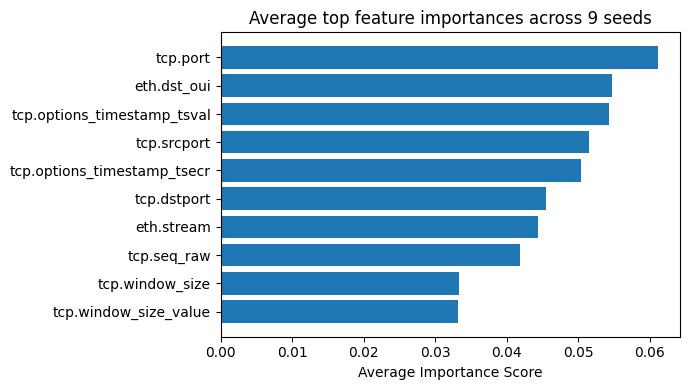

In [13]:
# Compute mean importances across seeds
mean_importances = np.mean(all_importances, axis=0)

# Sort features by mean importance (descending)
sorted_idx = np.argsort(mean_importances)[::-1][:top_n]
sorted_importances = mean_importances[sorted_idx]
sorted_feature_names = [X.columns[j] for j in sorted_idx]

# Plot the averaged importances
plt.figure(figsize=(7, 4))
plt.barh(range(len(sorted_feature_names)), sorted_importances)
plt.yticks(range(len(sorted_feature_names)), sorted_feature_names)
plt.gca().invert_yaxis()
plt.xlabel('Average Importance Score')
plt.title('Average top feature importances across 9 seeds')
plt.tight_layout()
plt.show()

Training classifier...
Calculating results...
Plotting...


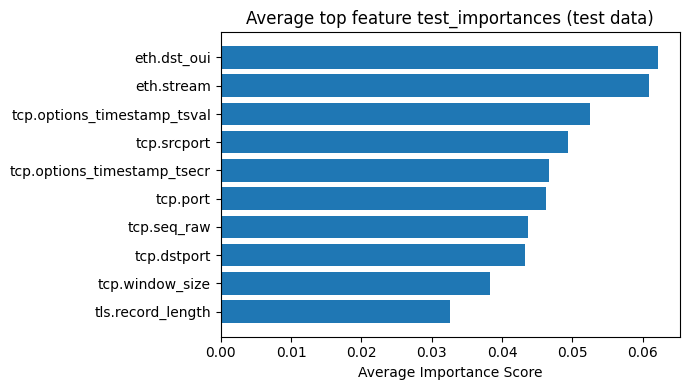

In [14]:
# Comparing results against test data

rf = RandomForestClassifier(
    n_estimators=200,
    n_jobs=-1, random_state=1)
print("Training classifier...")
rf.fit(X_test, y_test)

print("Calculating results...")
test_importances = rf.feature_importances_
test_sorted_idx = np.argsort(test_importances)[::-1][:top_n]
test_sorted_importances = test_importances[test_sorted_idx]
test_sorted_feature_names = [X_test.columns[j] for j in test_sorted_idx]

print("Plotting...")
plt.figure(figsize=(7, 4))
plt.barh(range(len(test_sorted_feature_names)), test_sorted_importances)
plt.yticks(range(len(test_sorted_feature_names)), test_sorted_feature_names)
plt.gca().invert_yaxis()
plt.xlabel('Average Importance Score')
plt.title('Average top feature test_importances (test data)')
plt.tight_layout()
plt.show()

In [15]:
# Feature selection
X = X[sorted_feature_names]
print(X.shape)
X.head()

(217509, 10)


,tcp.port,eth.dst_oui,tcp.options_timestamp_tsval,tcp.srcport,tcp.options_timestamp_tsecr,tcp.dstport,eth.stream,tcp.seq_raw,tcp.window_size,tcp.window_size_value
0,40767.000000,1362976.0,2.318916e+07,40767.000000,4.049397e+09,443.000000,0.0,9.123741e+07,2549.000000,2549.000000
1,443.000000,3181819.0,4.049398e+09,443.000000,2.318916e+07,40767.000000,0.0,6.799144e+08,836.000000,836.000000
2,40767.000000,1362976.0,2.318921e+07,40767.000000,4.049398e+09,443.000000,0.0,9.123750e+07,2549.000000,2549.000000
3,40767.000000,1362976.0,2.318937e+07,40767.000000,4.049398e+09,443.000000,0.0,9.123781e+07,2549.000000,2549.000000
4,22005.384225,13652648.0,1.550935e+09,22005.384225,1.568876e+09,20861.871223,1.0,1.338752e+09,10733.343593,3889.389424


In [16]:
# Feature scaling for numerical columns
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
numerical_cols = X.select_dtypes(include=['float64', 'int64']).columns
X[numerical_cols] = scaler.fit_transform(X[numerical_cols])
X[numerical_cols].head()

,tcp.port,eth.dst_oui,tcp.options_timestamp_tsval,tcp.srcport,tcp.options_timestamp_tsecr,tcp.dstport,eth.stream,tcp.seq_raw,tcp.window_size,tcp.window_size_value
0,9.554852e-01,-0.446687,-1.006126,9.554852e-01,1.636748e+00,-1.049240,-0.478796,-9.518787e-01,-0.340356,-1.629255e-01
1,-1.098122e+00,0.023567,1.645411,-1.098122e+00,-1.019906e+00,1.022841,-0.478796,-5.027062e-01,-0.411593,-3.711421e-01
2,9.554852e-01,-0.446687,-1.006126,9.554852e-01,1.636748e+00,-1.049240,-0.478796,-9.518787e-01,-0.340356,-1.629255e-01
3,9.554852e-01,-0.446687,-1.006126,9.554852e-01,1.636748e+00,-1.049240,-0.478796,-9.518784e-01,-0.340356,-1.629255e-01
4,1.852737e-16,2.730754,0.000000,1.852737e-16,1.573181e-16,0.000000,-0.388224,-1.819182e-16,0.000000,-1.658248e-16


In [17]:
# Combining into the processed dataset
df = pd.concat([y, X], axis=1)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 217509 entries, 0 to 217508
Data columns (total 11 columns):
 #   Column                       Non-Null Count   Dtype  
---  ------                       --------------   -----  
 0   DeviceName                   217509 non-null  object 
 1   tcp.port                     217509 non-null  float64
 2   eth.dst_oui                  217509 non-null  float64
 3   tcp.options_timestamp_tsval  217509 non-null  float64
 4   tcp.srcport                  217509 non-null  float64
 5   tcp.options_timestamp_tsecr  217509 non-null  float64
 6   tcp.dstport                  217509 non-null  float64
 7   eth.stream                   217509 non-null  float64
 8   tcp.seq_raw                  217509 non-null  float64
 9   tcp.window_size              217509 non-null  float64
 10  tcp.window_size_value        217509 non-null  float64
dtypes: float64(10), object(1)
memory usage: 18.3+ MB


In [18]:
# Final dataset
df.head()

,DeviceName,tcp.port,eth.dst_oui,tcp.options_timestamp_tsval,tcp.srcport,tcp.options_timestamp_tsecr,tcp.dstport,eth.stream,tcp.seq_raw,tcp.window_size,tcp.window_size_value
0,Dropcam,9.554852e-01,-0.446687,-1.006126,9.554852e-01,1.636748e+00,-1.049240,-0.478796,-9.518787e-01,-0.340356,-1.629255e-01
1,TPLink Router Bridge LAN (Gateway),-1.098122e+00,0.023567,1.645411,-1.098122e+00,-1.019906e+00,1.022841,-0.478796,-5.027062e-01,-0.411593,-3.711421e-01
2,Dropcam,9.554852e-01,-0.446687,-1.006126,9.554852e-01,1.636748e+00,-1.049240,-0.478796,-9.518787e-01,-0.340356,-1.629255e-01
3,Dropcam,9.554852e-01,-0.446687,-1.006126,9.554852e-01,1.636748e+00,-1.049240,-0.478796,-9.518784e-01,-0.340356,-1.629255e-01
4,TPLink Router Bridge LAN (Gateway),1.852737e-16,2.730754,0.000000,1.852737e-16,1.573181e-16,0.000000,-0.388224,-1.819182e-16,0.000000,-1.658248e-16


In [19]:
import time
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score

print("Execution start...")
start_time = time.time()

# Values to save best hyperparameters
best_accuracy = 0
best_params = None

# Saving values to later visualise against accuracy
data = list()
print("Data processing start...")
data_processing_start = time.time()

print("Test/train split...")

X = df.drop(['DeviceName'], axis=1)
y = df['DeviceName']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=80)

print("Hyperparameter tuning...")

iteration = 0

for k in [1, 3, 7]: # Arbitrary k values
    for weights in ['uniform', 'distance']:
        for p_val in [1, 2]: # Manhattan/Minkowski distance

            iteration += 1

            print(f"\tIteration {iteration}/12: k={k}, weights={weights}, p={p_val}")

            # Initialize and train the KNN classifier with current hyperparameters
            knn = KNeighborsClassifier(n_neighbors=k, weights=weights, p=p_val, n_jobs=-1)
            
            # Train the model
            print("\t\tModel training...", end=" ")
            training_start = time.time()
            knn.fit(X_train, y_train)
            training_time = time.time() - training_start
            print(f"{training_time:.4f}sec")

            # Evaluate the model
            print("\t\tModel evaluation...", end=" ")
            evaluation_start = time.time()
            y_pred = knn.predict(X_test)
            accuracy = accuracy_score(y_test, y_pred)
            # Check if the current model is the best
            if accuracy > best_accuracy:
                best_accuracy = accuracy
                best_params = (k, weights, p_val)
            evaluation_time = time.time() - evaluation_start
            print(f"{evaluation_time:.4f}sec")
            
            print(f"\t\tAccuracy: {accuracy:.8f}")
            if p_val == 1:
                p_str = "Manhattan"
            else:
                p_str = "Minkowski"
            data.append({'k': k, 'weights': weights, 'p': p_str, 'train_time': training_time, 'eval_time': evaluation_time, 'accuracy': accuracy})

data_processing_time = time.time() - data_processing_start
print("Data processing finished")

# Training phase
print("Final model training...", end=" ")
training_start = time.time()
best_knn = KNeighborsClassifier(n_neighbors=best_params[0], weights=best_params[1], p=best_params[2])
best_knn.fit(X_train, y_train)
training_time = time.time() - training_start
print(f"{training_time:.4f}sec")

# Test phase
print("Final model testing & evaluation...", end=" ")
evaluation_start = time.time()
y_pred_final = best_knn.predict(X_test)
test_accuracy = accuracy_score(y_test, y_pred_final)
evaluation_time = time.time() - evaluation_start
print(f"{evaluation_time:.4f}sec")

print("Accuracy:", accuracy)

total_execution_time = time.time() - start_time
print("Execution finished")

# Report results
total_execution_time, data_processing_time, training_time, evaluation_time, best_params, best_accuracy, test_accuracy
print(f"Total execution time: {total_execution_time:.4f}sec")
print(f"Data processing time: {data_processing_time:.4f}sec)")
print(f"Final model training time: {training_time:.4f}sec")
print(f"Final model evaluation time: {evaluation_time:.4f}sec")
print("Model parameters:", best_params)
print("Accuracy score:", test_accuracy)

Execution start...
Data processing start...
Test/train split...
Hyperparameter tuning...
	Iteration 1/12: k=1, weights=uniform, p=1
		Model training... 1.7999sec
		Model evaluation... 6.7511sec
		Accuracy: 0.99983909
	Iteration 2/12: k=1, weights=uniform, p=2
		Model training... 1.7666sec
		Model evaluation... 6.7513sec
		Accuracy: 0.99981610
	Iteration 3/12: k=1, weights=distance, p=1
		Model training... 1.7502sec
		Model evaluation... 2.3671sec
		Accuracy: 0.99983909
	Iteration 4/12: k=1, weights=distance, p=2
		Model training... 1.8667sec
		Model evaluation... 2.4421sec
		Accuracy: 0.99981610
	Iteration 5/12: k=3, weights=uniform, p=1
		Model training... 1.7561sec
		Model evaluation... 6.7847sec
		Accuracy: 0.99965519
	Iteration 6/12: k=3, weights=uniform, p=2
		Model training... 1.7607sec
		Model evaluation... 6.7739sec
		Accuracy: 0.99914946
	Iteration 7/12: k=3, weights=distance, p=1
		Model training... 1.8499sec
		Model evaluation... 2.3837sec
		Accuracy: 0.99981610
	Iteration 8

In [20]:
data_df = pd.DataFrame(data)
data_df.head()

,k,weights,p,train_time,eval_time,accuracy
0,1,uniform,Manhattan,1.799889,6.751065,0.999839
1,1,uniform,Minkowski,1.766587,6.751310,0.999816
2,1,distance,Manhattan,1.750181,2.367089,0.999839
3,1,distance,Minkowski,1.866703,2.442126,0.999816
4,3,uniform,Manhattan,1.756147,6.784662,0.999655


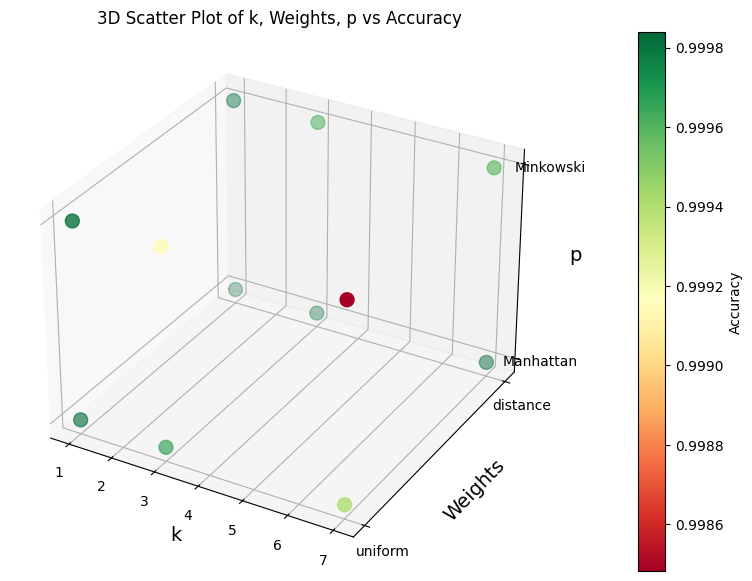

In [21]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import Normalize
from matplotlib import cm

# Convert categorical variables to numerical values
weights_map = {'uniform': 0, 'distance': 1}
p_map = {'Manhattan': 0, 'Minkowski': 1}

# Prepare data for plotting
k_values = np.array(data_df['k'])
weights_values = np.array([weights_map[w] for w in data_df['weights']])
p_values = np.array([p_map[p] for p in data_df['p']])
accuracy_values = np.array(data_df['accuracy'])

# Normalize Accuracy for color mapping
norm = Normalize(vmin=accuracy_values.min(), vmax=accuracy_values.max())

# Use a custom colormap from red to green
cmap = cm.RdYlGn # Reversed RdYlGn colormap (Red to Green)

# Create a 3D scatter plot
fig = plt.figure(figsize=(23, 7))
ax = fig.add_subplot(111, projection='3d')

# Scatter plot with colors based on accuracy, mapped through the colormap
sc = ax.scatter(k_values, weights_values, p_values, c=accuracy_values, cmap=cmap, norm=norm, s=100)

# Set labels
ax.set_xlabel('k', fontsize=14)
ax.set_ylabel('Weights', fontsize=14)
ax.set_zlabel('p', fontsize=14)

# Custom ticks for 'weights' axis
ax.set_yticks([0, 1])
ax.set_yticklabels(['uniform', 'distance'])

# Custom ticks for 'p' axis
ax.set_zticks([0, 1])
ax.set_zticklabels(['Manhattan', 'Minkowski'])

# Add a colorbar to reflect the accuracy
cbar = fig.colorbar(sc, ax=ax)
cbar.set_label('Accuracy')

plt.title('3D Scatter Plot of k, Weights, p vs Accuracy')
plt.show()

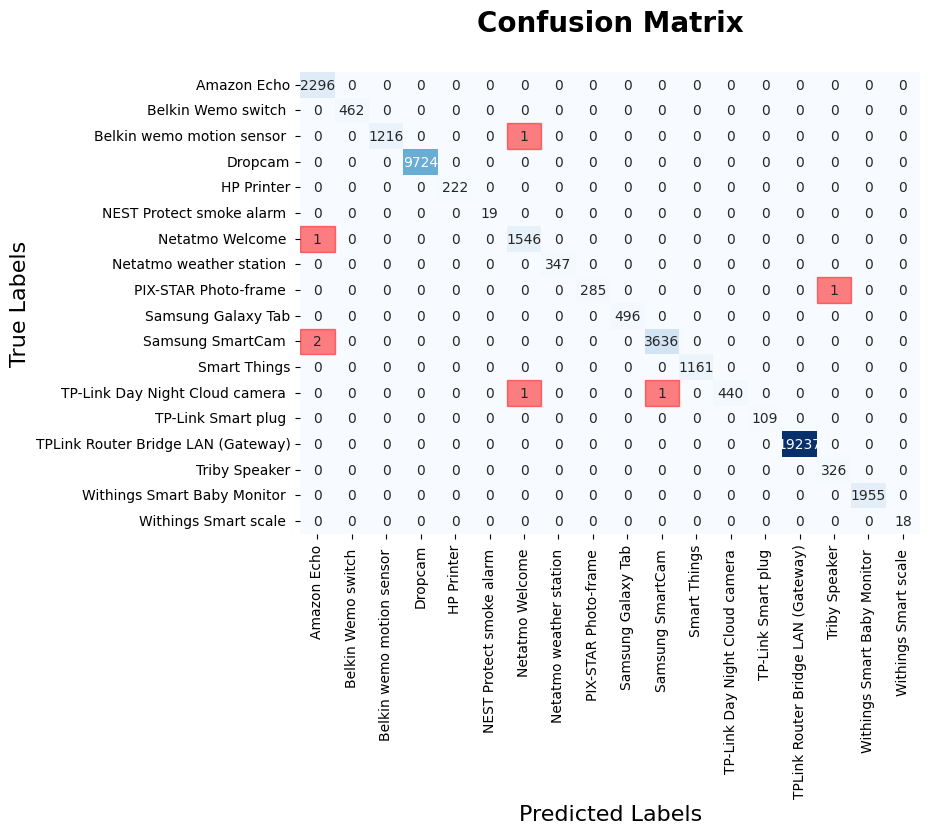

In [ ]:
import seaborn as sns
from sklearn.metrics import confusion_matrix

# Assuming y_test is the true labels and y_pred_final is the model predictions
# Generate confusion matrix
cm = confusion_matrix(y_test, y_pred_final)

# Create a custom colormap with bright red for non-TP values
cmap = sns.color_palette("Blues", as_cmap=True)

# Create a figure
plt.figure(figsize=(8, 6))

# Plot the heatmap with a custom colormap
sns.heatmap(cm, annot=True, fmt='d', cmap=cmap, cbar=False,
            xticklabels=best_knn.classes_, yticklabels=best_knn.classes_)

# Loop over the matrix to manually set non-TP cells to bright red
for i in range(len(cm)):
    for j in range(len(cm[i])):
        if i != j and cm[i, j] != 0: # Non-TP values
            plt.gca().add_patch(plt.Rectangle((j, i), 1, 1, color='red', alpha=0.5))

plt.xlabel('Predicted Labels', fontsize=16)
plt.ylabel('True Labels', fontsize=16)
plt.title('Confusion Matrix\n', fontsize=20, fontweight='bold')
plt.show()